# SandBox for Chest Xray Dataset Images

## Overview:

The overall goal of this project is to explore the use of a simple Variational Autoencoder (VAE) architecture for reconstructing chest xray images from the ChestX-ray 8 dataset. The full dataset is > 100,000 images corresponding to ~30,000 patients, but so far I've only downloaded about 25,000 and trained on the first 5000 images in the data directory.

Notebook provides basic exploration of image data used for training VAE defined in VAE.py, corresponding tabular data, and the model that results from running VAE_train.py.

## Data Source


### Publication

https://arxiv.org/abs/1705.02315

### URL

https://nihcc.app.box.com/v/ChestXray-NIHCC/folder/37178474737

In [1]:
import torch
from torchvision import transforms
import VAE
import numpy as np
import pandas as pd
import seaborn as sns
from skimage import io
from matplotlib import pyplot as plt
from matplotlib import cm
from warnings import warn
import os
import re
import datetime
from tqdm import tqdm


In [2]:
# set random seed
np.random.seed(42)

In [3]:
top_dir = '/home/whitleyo/projects/ChestXray8VAE'
# top_dir = 'D:\\projects\\chest_XRay_8'
data_dir = os.path.join(top_dir, 'data')
image_dir = os.path.join(data_dir, 'images')
output_dir = os.path.join(top_dir, 'results')

In [4]:
os.listdir(data_dir)

['Data_Entry_2017_v2020.csv',
 '.ipynb_checkpoints',
 'ChestXray_NIHCC_Download.py',
 'results',
 'images']

# Examine Image Data

Modified code from [here](https://matplotlib.org/3.3.3/gallery/images_contours_and_fields/multi_image.html#sphx-glr-gallery-images-contours-and-fields-multi-image-py)

## Check a few typical examples

In [5]:
# number of images downloaded
len(os.listdir(image_dir))

112120

In [6]:
# example image files
ex_img_files = os.listdir(image_dir)[:5]
ex_img_files

['00019475_004.png',
 '00025787_053.png',
 '00017605_000.png',
 '00007087_000.png',
 '00018865_045.png']

In [7]:
len(ex_img_files)

5

In [8]:

def implot(imgs, rows, columns, fig_width, fig_height, channels = 1):

    
    m = 0
    if channels == 1:
        img_list = imgs
    else:
        img_list = []
        if isinstance(imgs, np.ndarray):
            n_imgs = imgs.shape[0]
        else:
            n_imgs = len(imgs)
            imgs = np.array(imgs)
            
        for i in range(n_imgs):
            for c in range(channels):
                img_list.append(imgs[i, :, :, c])
            
        rows = n_imgs
        columns = channels
        print('ignoring arguments for rows and columns')
       
    fig, axs = plt.subplots(rows, columns, figsize=(fig_width, fig_height))
    for i in range(rows):
        for j in range(columns):
            print(m)
            ex_img = img_list[m]
            if rows == 1:
                sns.heatmap(ex_img, ax = axs[j])
            elif columns == 1:
                sns.heatmap(ex_img, ax = axs[i])
            else:
                sns.heatmap(ex_img, ax = axs[i, j])
            m += 1

    plt.show()
img_list = [io.imread(os.path.join(image_dir, ex_img_files[m])) for m in range(len(ex_img_files))]    
# implot(img_list, 1, 5, 18, 3)


## Check a random sample of 1000 images for image 'shape'

Earlier I had a problem with some of the images not being 1024 x 1024 x 1, so I'm going to have to confirm that there are are in fact images with multiple 'channels' or a depth of > 1, and that this isn't some artifact happening with one of the pytorch transforms.

100%|███████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:12<00:00, 79.90it/s]
/tmp/ipykernel_3979/1662331631.py:15: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(img_nc[:,2])


<Axes: ylabel='Density'>

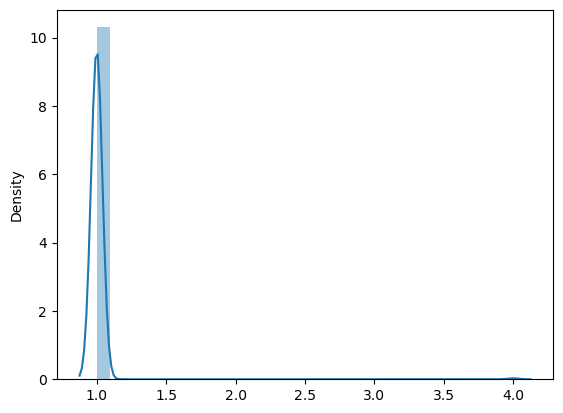

In [9]:
# check 1000 random images for having more than 1 channel

random_img_files = np.random.choice(os.listdir(image_dir), replace = False, size = 1000)
img_nc = np.repeat(-1, 3000).reshape((1000, 3))

for i in tqdm(range(1000)):
    img_i = io.imread(os.path.join(image_dir, random_img_files[i]))
    if len(img_i.shape) > 2:
        shape_i = img_i.shape
        img_nc[i] = img_i.shape
    else: 
        img_nc[i] = np.concatenate((img_i.shape, [1]))
    
    
sns.distplot(img_nc[:,2])

In [10]:
np.sum(np.greater(img_nc[:, 2], 1))

np.int64(3)

In [11]:
# it appears that some subset of the images has a depth of 4
img_nc[np.where(np.greater(img_nc[:, 2], 1)), :]

array([[[1024, 1024,    4],
        [1024, 1024,    4],
        [1024, 1024,    4]]])

In [12]:
img_nc[:5,:]

array([[1024, 1024,    1],
       [1024, 1024,    1],
       [1024, 1024,    1],
       [1024, 1024,    1],
       [1024, 1024,    1]])

In [13]:
four_channel_img = np.array([io.imread(os.path.join(image_dir, x)) for x in random_img_files[np.where(np.greater(img_nc[:, 2], 1))]])

In [14]:
# Check a few examples of "four channel" images. rows are cases, columns are 'channels'
# implot(four_channel_img[:4, :, :, :], None, None, 20, 20, channels = 4)

/tmp/ipykernel_3979/3586577630.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(four_channel_img[:, :, :, 3].flatten())
/home/whitleyo/anaconda3/envs/pytorch_chx8_vae/lib/python3.13/site-packages/seaborn/distributions.py:2496: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  kdeplot(**{axis: a}, ax=ax, color=kde_color, **kde_kws)


<Axes: ylabel='Density'>

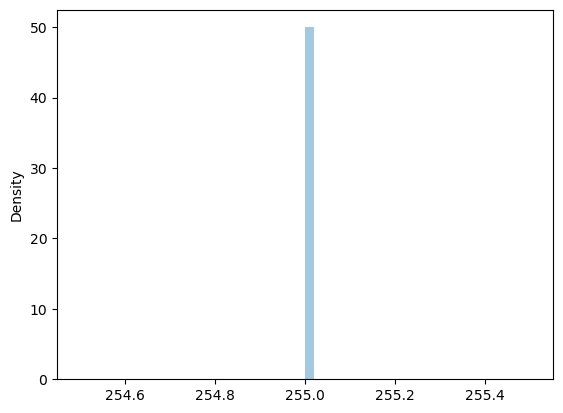

In [15]:
sns.distplot(four_channel_img[:, :, :, 3].flatten())

In [16]:
# I suspect that the first 3 channels are all identical. This turns out to be true
print(np.all(np.equal(four_channel_img[:, :, :, 0].flatten(), four_channel_img[:, :, :, 1].flatten())))
print(np.all(np.equal(four_channel_img[:, :, :, 1].flatten(), four_channel_img[:, :, :, 2].flatten())))

True
True


It appears that for some subset of the images, the image got copied 3 times, potentially into RGBA format.

## Check mean intensities of first 5 images we looked at

/tmp/ipykernel_3979/3479855833.py:6: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(img_means)


<Axes: ylabel='Density'>

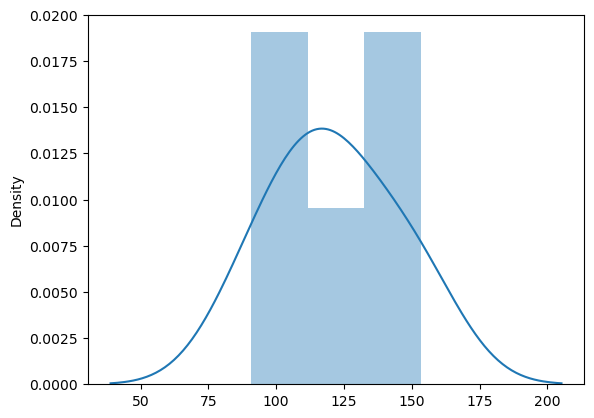

In [17]:
# check means of images
img_means = []
for i in range(len(img_list)):
    img_means.append(np.mean(img_list[i]))

sns.distplot(img_means)

/tmp/ipykernel_3979/1427778520.py:6: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(img_maxes)


<Axes: ylabel='Density'>

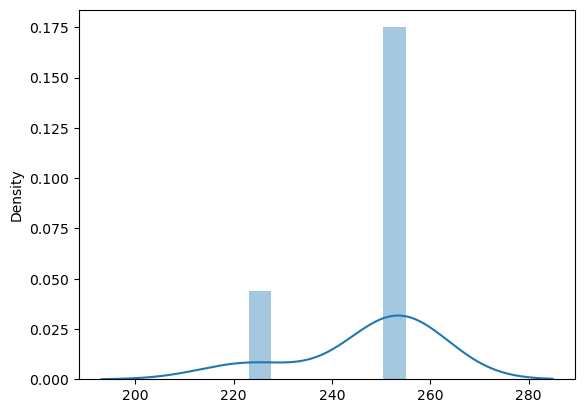

In [18]:
# check maxes of images
img_maxes = []
for i in range(len(img_list)):
    img_maxes.append(np.max(img_list[i]))

sns.distplot(img_maxes)

In [19]:
# yep this is a 
np.max(img_maxes)

np.uint8(255)

/tmp/ipykernel_3979/1319027117.py:6: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(img_mins)
/home/whitleyo/anaconda3/envs/pytorch_chx8_vae/lib/python3.13/site-packages/seaborn/distributions.py:2496: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  kdeplot(**{axis: a}, ax=ax, color=kde_color, **kde_kws)


<Axes: ylabel='Density'>

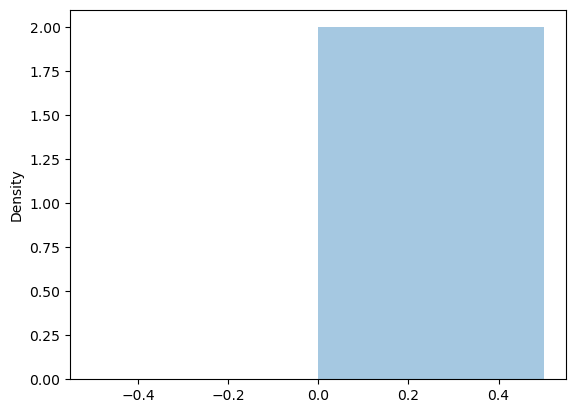

In [20]:
# check maxes of images
img_mins = []
for i in range(len(img_list)):
    img_mins.append(np.min(img_list[i]))

sns.distplot(img_mins)

In [21]:
np.min(img_mins)

np.uint8(0)

In [22]:
# mean intensity
mean_intensity = np.mean(np.array(img_list))
mean_intensity

np.float64(121.02863426208496)

In [23]:
# std deviation
std_intensity = np.std(np.array(img_list))
std_intensity

np.float64(69.08893288737917)

In [24]:
# let's compute the same but after calling ToTensor, which should 0-1 normalize everything
# mean
transforms.ToTensor()(np.array(img_list)).mean()

tensor(0.4746)

In [25]:
transforms.ToTensor()(np.array(img_list)).std()

tensor(0.2709)

In [26]:
my_transform = VAE.create_transform_zero_one_norm(resize_width=256)

In [27]:
img_list[0]

array([[ 1,  1,  1, ...,  1,  1,  1],
       [ 1,  1,  1, ...,  1,  1,  1],
       [ 1,  1,  1, ...,  1,  1,  1],
       ...,
       [43, 84, 85, ...,  7,  8,  5],
       [43, 81, 83, ...,  8,  8,  5],
       [21, 39, 40, ...,  5,  4,  3]], shape=(1024, 1024), dtype=uint8)

In [28]:
img_list[0]

array([[ 1,  1,  1, ...,  1,  1,  1],
       [ 1,  1,  1, ...,  1,  1,  1],
       [ 1,  1,  1, ...,  1,  1,  1],
       ...,
       [43, 84, 85, ...,  7,  8,  5],
       [43, 81, 83, ...,  8,  8,  5],
       [21, 39, 40, ...,  5,  4,  3]], shape=(1024, 1024), dtype=uint8)

In [29]:
torch.max(transforms.ToTensor()(img_list[0]))

tensor(1.)

# Create XRayDataSet Objects for Indexing Data
Note to self: in future, save Trainer object used for training + testing. Given same seed, Trainer object should split data in exact same manner as was done for training model

In [30]:
table_data = pd.read_csv(os.path.join(data_dir, 'Data_Entry_2017_v2020.csv'))
table_data = table_data.iloc[0:5000, :]
VAE_DS = VAE.XRayDataset(table_data=table_data,
                         root_dir=image_dir,
                         transform=VAE.create_transform(resize_width=256))

VAE_Trainer = VAE.Trainer(XRayDS=VAE_DS)

5000 images common to root_dir (112120 images) and table data (5000 images)
No. Train:4000 No. Test:1000
4000 images common to root_dir (112120 images) and table data (4000 images)
1000 images common to root_dir (112120 images) and table data (1000 images)
using GPU


In [31]:
VAE_DS[1]['image'].shape

torch.Size([1, 256, 256])

In [32]:
VAE_DS[2]['image'].max()

tensor(1.8672)

# Exploration of Tabular Data

We explore the distribution of Finding Labels and other image related tabular data, such as patient age, patient ID, and patient gender

In [33]:
total_images = VAE_DS.__len__()
total_images

5000

In [34]:
VAE_DS.table_data

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Sex,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y]
0,00000001_000.png,Cardiomegaly,0,1,57,M,PA,2682,2749,0.143,0.143
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,0.143
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,0.168
3,00000002_000.png,No Finding,0,2,80,M,PA,2500,2048,0.171,0.171
4,00000003_001.png,Hernia,0,3,74,F,PA,2500,2048,0.168,0.168
...,...,...,...,...,...,...,...,...,...,...,...
4995,00001335_003.png,No Finding,3,1335,19,F,PA,2048,2500,0.168,0.168
4996,00001335_004.png,No Finding,4,1335,19,F,PA,2992,2991,0.143,0.143
4997,00001335_005.png,No Finding,5,1335,22,F,PA,2946,2948,0.143,0.143
4998,00001335_006.png,Infiltration,6,1335,23,F,PA,2992,2729,0.143,0.143


In [35]:
VAE_DS.one_hot_all_labels('Finding Labels')

In [36]:
VAE_DS.table_data.loc[:, VAE_DS.get_label_names('Finding Labels')]

,Atelectasis,Cardiomegaly,Consolidation,Edema,Effusion,Emphysema,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0
2,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
4,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
4996,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
4997,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
4998,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0


In [37]:
VAE_DS.get_multi_label('Finding Labels')

In [38]:
# check distribution of Finding Labels. 
label_names = np.concatenate((VAE_DS.get_label_names('Finding Labels'), np.array(['Finding Labels_IsMultiLabel'])))
for lab in label_names:
    print("{}: {}".format(lab, np.sum(VAE_DS.table_data[lab].to_numpy())))

Atelectasis: 460
Cardiomegaly: 196
Consolidation: 205
Edema: 90
Effusion: 487
Emphysema: 125
Fibrosis: 172
Hernia: 27
Infiltration: 830
Mass: 161
No Finding: 2755
Nodule: 214
Pleural_Thickening: 165
Pneumonia: 65
Pneumothorax: 199
Finding Labels_IsMultiLabel: 824


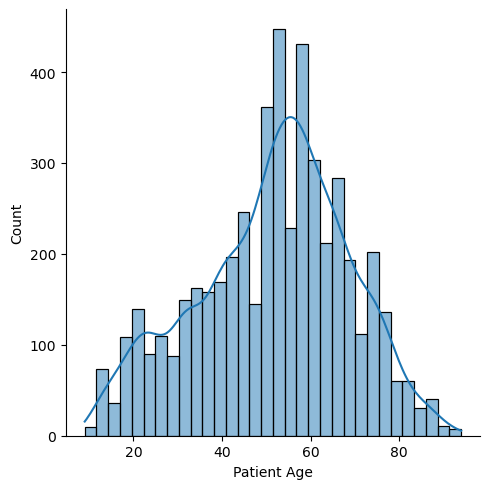

In [39]:
# Check Distribution of Ages
sns.displot(VAE_DS.table_data['Patient Age'], kde = True)

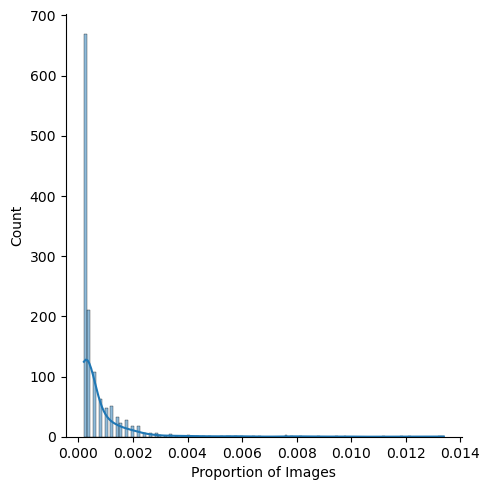

In [40]:
# check proportion of images accounted for by each patient.
# It turns out that a small proportion of patients each account for 5 in every 1000 images or so.
# Still, this isn't horrifyinglying biased towards any individual patient
g = sns.displot(VAE_DS.table_data['Patient ID'].value_counts()/np.float32(total_images), kde = True)
g.set_axis_labels("Proportion of Images", "Count")

In [41]:
# # Check Male/Female Distribution
# VAE_DS.table_data['Patient Gender'].value_counts()

In [42]:
# # Check Distribution of ages among genders
# sns.violinplot(data = VAE_DS.table_data, x = 'Patient Gender', y = 'Patient Age')

# Examine Training Results

We collect a record of the running stats. Note that Epoch 21 represents the final pass through the data with no backpropagation. Training time was approximately 3 minutes per epoch with a batch size of 50 for 5000 samples in an 80/20 train test split.


In [43]:
running_stats = torch.load(os.path.join(output_dir, 'VAE_running_stats.pt'), weights_only=False)


In [44]:
running_stats_df_train = pd.DataFrame.from_dict(running_stats['train'])
running_stats_df_train['dataset'] = np.repeat('train', running_stats_df_train.shape[0])
running_stats_df_train['epoch'] = np.arange(0, running_stats_df_train.shape[0]) + 1
running_stats_df_train

,avg_elbo,avg_log_pxz,dataset,epoch
0,-975770.375000,-933424.812500,train,1
1,-172535.046875,-163536.546875,train,2
2,-126976.890625,-116851.109375,train,3
3,-104371.750000,-94018.539062,train,4
4,-93524.046875,-83025.023438,train,5
5,-85186.140625,-74762.382812,train,6
6,-81253.062500,-70871.851562,train,7
7,-75922.820312,-65647.039062,train,8
8,-72119.421875,-61947.476562,train,9
9,-68912.937500,-58838.113281,train,10


In [45]:
running_stats_df_test = pd.DataFrame.from_dict(running_stats['test'])
running_stats_df_test['dataset'] = np.repeat('test', running_stats_df_test.shape[0])
running_stats_df_test['epoch'] = np.arange(0, running_stats_df_test.shape[0]) + 1
running_stats_df_test

,avg_elbo,avg_log_pxz,dataset,epoch
0,-215913.156250,-208260.703125,test,1
1,-138189.593750,-129070.117188,test,2
2,-110664.960938,-100328.820312,test,3
3,-95003.937500,-84380.781250,test,4
4,-85600.218750,-75304.812500,test,5
5,-82208.500000,-71834.812500,test,6
6,-80273.710938,-69930.421875,test,7
7,-76821.007812,-66816.351562,test,8
8,-70725.523438,-61037.605469,test,9
9,-69063.976562,-59328.773438,test,10


In [46]:
running_stats_df = pd.concat([running_stats_df_train, running_stats_df_test])
running_stats_df['diff_avg_elbo_avg_log_pxz'] = running_stats_df['avg_elbo'] - running_stats_df['avg_log_pxz']
running_stats_df.head()

,avg_elbo,avg_log_pxz,dataset,epoch,diff_avg_elbo_avg_log_pxz
0,-975770.375000,-933424.812500,train,1,-42345.562500
1,-172535.046875,-163536.546875,train,2,-8998.500000
2,-126976.890625,-116851.109375,train,3,-10125.781250
3,-104371.750000,-94018.539062,train,4,-10353.210938
4,-93524.046875,-83025.023438,train,5,-10499.023438


In [47]:
running_stats_df.tail()

,avg_elbo,avg_log_pxz,dataset,epoch,diff_avg_elbo_avg_log_pxz
46,-58737.621094,-50347.488281,test,47,-8390.132812
47,-54626.289062,-46015.375000,test,48,-8610.914062
48,-55711.605469,-46720.023438,test,49,-8991.582031
49,-57301.031250,-48482.238281,test,50,-8818.792969
50,-57301.023438,-48482.234375,test,51,-8818.789062


<Axes: xlabel='epoch', ylabel='avg_elbo'>

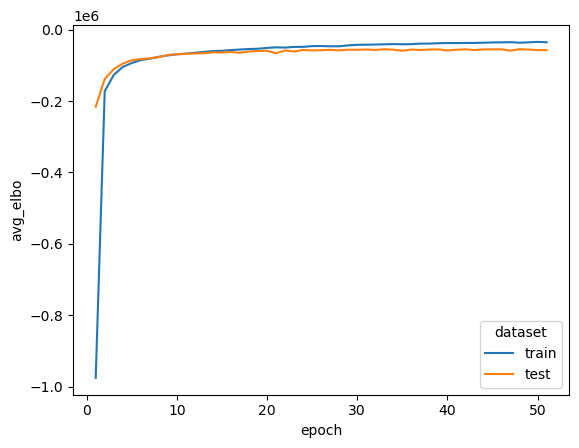

In [48]:
# avg ELBO (objective function across batches) vs epoch
sns.lineplot(x="epoch", y="avg_elbo",
             hue="dataset",
             data=running_stats_df)

<Axes: xlabel='epoch', ylabel='avg_log_pxz'>

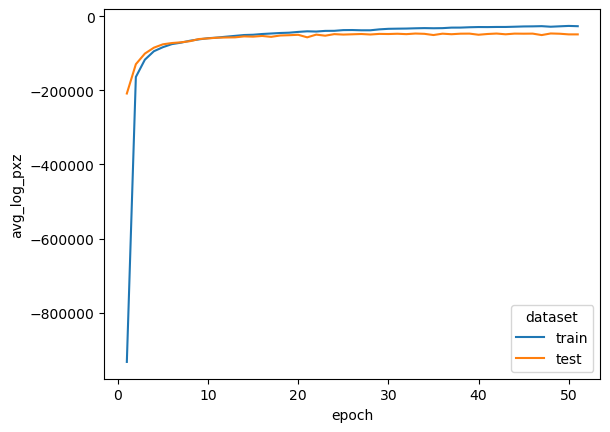

In [49]:
# avg log p(x|z) vs epoch
sns.lineplot(x="epoch", y="avg_log_pxz",
             hue="dataset",
             data=running_stats_df)

<Axes: xlabel='epoch', ylabel='diff_avg_elbo_avg_log_pxz'>

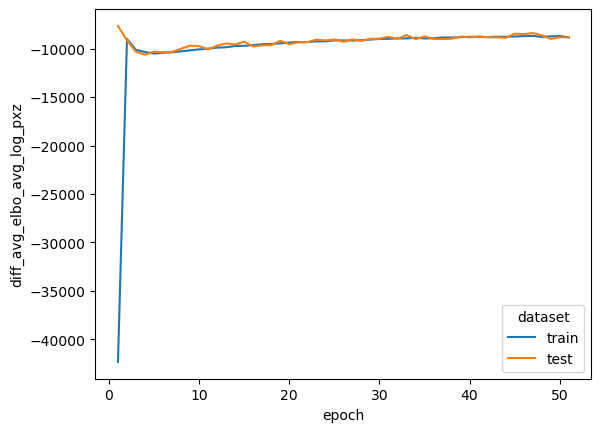

In [50]:
# difference between avg elbo and avg log p(x|z)
sns.lineplot(x="epoch", y="diff_avg_elbo_avg_log_pxz",
             hue="dataset",
             data=running_stats_df)

In [51]:
# Examine some images produced by the autoencoder.
VAE_trained = VAE.VariationalAutoEncoder(input_size=256,
                                       # fc0_dims=1024,
                                       latent_dims=512,
                                       n_conv=4,
                                       F=4,
                                       P=1,
                                       S=2,
                                       c=32,
                                       use_batch_norm=False,
                                       output='Gaussian')
params_dict = torch.load(os.path.join(output_dir, 'VAE_state_dict_trained.pt'))
VAE_trained.load_state_dict(params_dict)
VAE_trained.set_train_status(training = False)
VAE_trained.eval()

VariationalAutoEncoder(
  (encoder): Encoder(
    (conv_layers): ModuleList(
      (0): Conv2d(1, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (1): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (3): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    )
    (fc_mu): Linear(in_features=65536, out_features=512, bias=True)
    (fc_logvar): Linear(in_features=65536, out_features=512, bias=True)
  )
  (decoder): Decoder(
    (tconv_layers): ModuleList(
      (0): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (1): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (2): ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (3): ConvTranspose2d(32, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    )
    (fc1): Linear(in_features=512, out_features=65536, bi

In [52]:
sum(p.numel() for p in VAE_trained.parameters() if p.requires_grad)

102107841

In [53]:
orig_imgs = []
recon_imgs = []
for i in range(10):
    img_i = VAE_DS[i]['image']
    img_i = torch.reshape(img_i, (1, img_i.shape[0], img_i.shape[1], img_i.shape[2]))
    orig_imgs.append(img_i[0][0].numpy())
    recon_img_i, _, _, _ = VAE_trained.forward(img_i)
    recon_imgs.append(recon_img_i[0][0].detach().numpy())

0
1
2
3
4
5
6
7
8
9


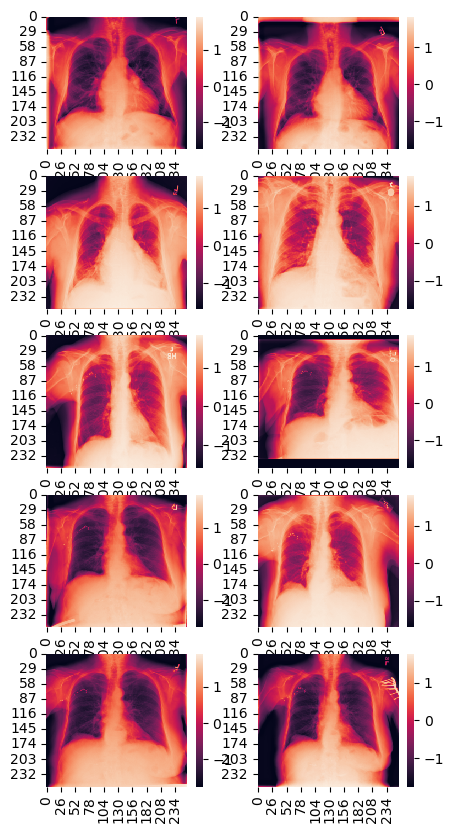

In [54]:
implot(orig_imgs, rows = 5, columns = 2, fig_width = 5, fig_height = 10, channels = 1)

0
1
2
3
4
5
6
7
8
9


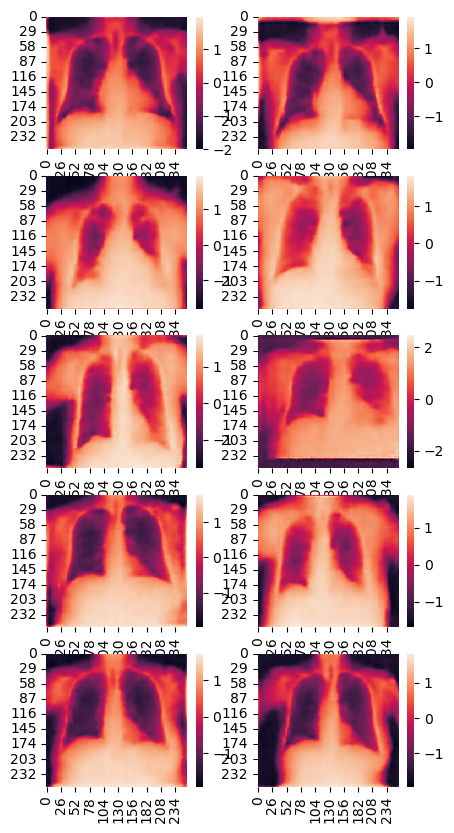

In [55]:
implot(recon_imgs, rows = 5, columns = 2, fig_width = 5, fig_height = 10, channels = 1)

The images look like essentially blurred versions of the originals. It appears that using a sigmoid function forces sharper contrasts. Something we could look into might be a mixed bernoulli + gaussian penalty for the reconstruction error term

/tmp/ipykernel_3979/2057185483.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(orig_imgs[0])


<Axes: ylabel='Density'>

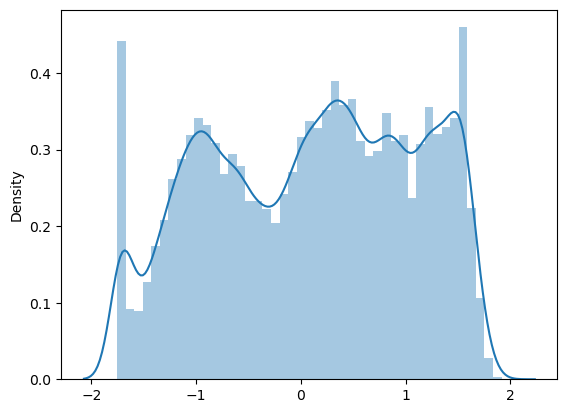

In [56]:
sns.distplot(orig_imgs[0])

/tmp/ipykernel_3979/3708246948.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(recon_imgs[0])


<Axes: ylabel='Density'>

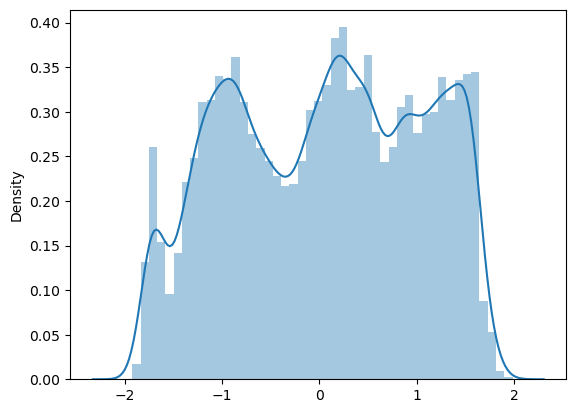

In [57]:
sns.distplot(recon_imgs[0])

Overall, it appears that the log p(x|z) term seems to dominate the loss, and that we're seriously underfitting. In a future iteration of the project, should record the KL divergence between q(z) and p(z). Should probably consider using an architecture similar to that used for the Chest-Xray 8 paper (but in VAE form), or using a pre-trained model such as VGG.